In [1]:
#Import
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import ast
from scipy import stats
from helpers import *

## 1. Open Bechdel and CMU datasets

### 1.a. Bechdel Test

In [2]:
#Open Bechdel Test JSON object 
json_file_path = './data/Bechdel_get_all.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Convert JSON to DataFrame
df_bech = pd.DataFrame(json_data)

#Show Bechdel Test DataFrame
print('Bechdel Test dataset has', len(df_bech), 'entries')
df_bech.head()

Bechdel Test dataset has 10136 entries


,imdbid,year,rating,id,title
0,3155794,1874,0,9602,Passage de Venus
1,14495706,1877,0,9804,La Rosace Magique
2,2221420,1878,0,9603,Sallie Gardner at a Gallop
3,12592084,1878,0,9806,Le singe musicien
4,7816420,1881,0,9816,Athlete Swinging a Pick


### 1.b. CMU Movies metadata

In [ ]:
#Open Movie dataFrame
df = pd.read_csv('./data/movie.metadata.tsv', names = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                                                   'Movie box office revenue','Movie runtime','Movie languages (Freebase ID:name tuples)',
                                                   'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)'],sep='\t')
df['Movie release date']=pd.to_datetime(df['Movie release date'], format='%Y-%m-%d', errors='coerce')
df['year'] = df['Movie release date'].dt.year
# Display the first few rows of the dataframe
print('CMU Movies dataset has', len(df), 'entries')
df.head()

## 2. Explore the amount of data available in both datasets

### 2.a. Amount of data across the years 

This first overview let us know the size of the two datasets across the years. This first analysis counts all movies, regardless of the possible missing values in the columns of the dataframe. 

(1873.0, 2024.0)

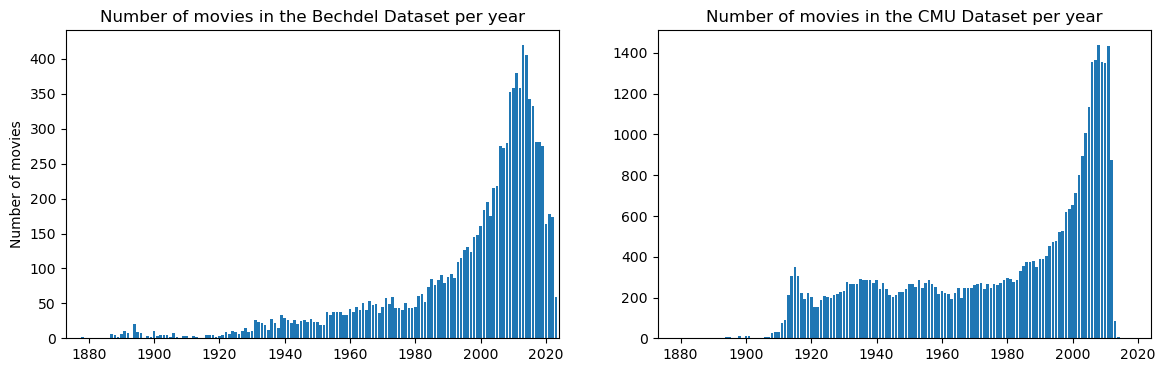

In [4]:
#Histogram of number of movies per year in the bechdel Dataset
plt.figure(figsize=(14,4))

#Bechdel, group by year
plt.subplot(1,2,1)
plt.bar(df_bech.groupby('year').count().index, df_bech.groupby('year').count()['id'])
plt.title('Number of movies in the Bechdel Dataset per year')
plt.ylabel('Number of movies')
plt.xlim((1873,2024))

#CMU
plt.subplot(1,2,2)
plt.bar(df.groupby('year').count().index, df.groupby('year').count()['Movie name'])
plt.title('Number of movies in the CMU Dataset per year')
plt.xlim((1873,2024))

In order to compare the two, it is easier to show the two evolutions on line plots:

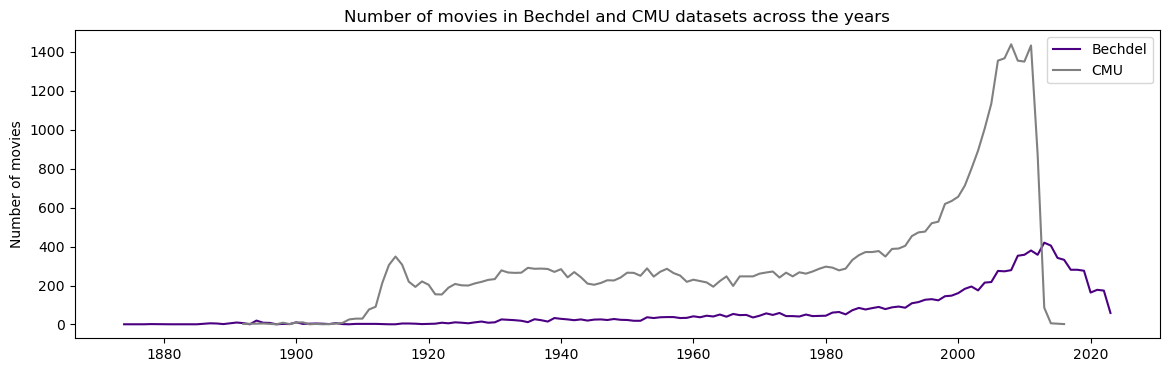

In [5]:
#Line plot
plt.figure(figsize=(14,4))
plt.plot(df_bech.groupby('year').count().index, df_bech.groupby('year').count()['id'], color='indigo', label='Bechdel')
plt.plot(df.groupby('year').count().index, df.groupby('year').count()['Movie name'], color='gray', label='CMU')
plt.ylabel('Number of movies')
plt.title('Number of movies in Bechdel and CMU datasets across the years')
plt.legend()

Although the Bechdel test is about two 8 times smaller than CMU, it follows the same increasing trend with years. It appears that the CMU has no data after 2016, whereas Bechdel contains data until 2023. Thus, it won't be possible to perform analysis on the last five years. 

### 2.b Check amount of Nans values

In [6]:
#Iterate over different columns of Bechdel dataset to check missing values:
for col in df_bech.columns:
    nan_rating_count = df_bech[col].isna().sum()
    print('Number of NaN values in column',col, nan_rating_count)

Number of NaN values in column imdbid 0
Number of NaN values in column year 0
Number of NaN values in column rating 0
Number of NaN values in column id 0
Number of NaN values in column title 0


No values are missing in the Bechdel dataset, which is expected, because this dataset is collaborative, and data get double checked before being published on the website.

In [7]:
#Iterate over columns of CMU movies dataset to check missing values:
for col in df.columns:
    nan_rating_count = df[col].isna().sum()
    print('Proportion of NaN values in column',col, round(100*(nan_rating_count/len(df)),2),'%')

Proportion of NaN values in column Wikipedia movie ID 0.0 %
Proportion of NaN values in column Freebase movie ID 0.0 %
Proportion of NaN values in column Movie name 0.0 %
Proportion of NaN values in column Movie release date 51.83 %
Proportion of NaN values in column Movie box office revenue 89.72 %
Proportion of NaN values in column Movie runtime 25.02 %
Proportion of NaN values in column Movie languages (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column Movie countries (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column Movie genres (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column year 51.83 %


We observe that there are no missing values in the Movie name column. Thus, we will not miss rows when performing the merge on this column. However, half of the dataset has missing release date, and the box office revenue is missing for about 90 % of the movies.

## 3. Merge the two datasets

### 3.a Merge on titles ?

The first idea was to perform a merge based on movie titles:

In [8]:
#Inner Join on Bechdel data and Movie data on "title" and "Movie Name"
# Perform inner join
merged_df = pd.merge(df_bech, df, left_on='title', right_on='Movie name', how='inner')
print(100*round(len(merged_df)/len(df_bech),2),'% of Bechdel movies are in the merged dataset')

62.0 % of Bechdel movies are in the merged dataset


In [9]:
#We must check that merging on name has no weaknesses, ie that there are no pairs of distinct movies with the same title
duplicate_rows = df[df.duplicated(subset=['Movie name'], keep=False)]
if not duplicate_rows.empty:
    print("Duplicate values found in 'Movie Name' column:")
    print(len(duplicate_rows), 'rows over',len(df), 'have the same Movie name! It represents',round(100*(len(duplicate_rows)/len(df)),2),'% of the CMU dataset')
else:
    print("No duplicate values found in 'Movie Name' column.")

Duplicate values found in 'Movie Name' column:
10650 rows over 81741 have the same Movie name! It represents 13.03 % of the CMU dataset


13 % of the dataset are distinct movies having the same name. We conclude that perfomring a merge based on movie Title is not a good idea. Therefore, we must find a way to obtain the Wikipedia Page Ids of all movies in the Bechdel dataset. We can do an API request with the movie title and year. This has a high computational time. We obtain a column in the Bechdel dataset with the Wikipedia ID

### 3.b Merge on Wikipedia IDs

#### Add Wikipedia IDs to Bechdel dataset

The Bechdel dataset Wikipedia ID column can be filled by applying the get_wikipedia_id on all the rows. This takes an hour, so it won't be run in the future. We will rather save the obtained table the first time, and load it when running the Notebook

In [52]:
##Takes 1 hour !!!!!
df_bech['WikiID']=None
for index, row in tqdm(df_bech.iterrows(), total=len(df_bech), desc="Processing Rows"):
    movie_name = row['title']
    release_date = row['year']
    wiki_id = get_wikipedia_page_id(movie_name,release_date)
#Fill the new column in the Bechdel dataframe
    df_bech.at[index, 'WikiID'] = wiki_id


Processing Rows: 100%|██████████████████| 10136/10136 [1:42:36<00:00,  1.65it/s]


In [56]:
#Save the obtained dataframe with IDs to load it next times
df_bech.to_csv('df_bech_with_wikiID.csv')

In [57]:
#Load the saved bechdel dataframe with wiki IDs
df_bech = pd.read_csv('./data/df_bech_with_wikiID.csv')
df_bech.head()

,Unnamed: 0,imdbid,year,rating,id,title,WikiID
0,0,3155794.0,1874,0,9602,Passage de Venus,47863608.0
1,1,14495706.0,1877,0,9804,La Rosace Magique,385718.0
2,2,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155.0
3,3,12592084.0,1878,0,9806,Le singe musicien,385718.0
4,4,7816420.0,1881,0,9816,Athlete Swinging a Pick,60115.0


#### Merge CMU and datasets on Wikipedia IDs

In [61]:
#Merge the two dataframes on Wikipedia IDs
merged_df = pd.merge(df_bech, df, left_on='WikiID', right_on='Wikipedia movie ID', how='inner')
print('The merged Bechdel movie dataset has', len(merged_df), 'movies')
print(100*round((len(merged_df)/len(df_bech)),2),'% of Bechdel movies are in the merged dataset')

The merged Bechdel movie dataset has 5816 movies
56.99999999999999 % of Bechdel movies are in the merged dataset


We notice that certain movies in the Bechdel dataset are not in the CMU dataset because they are not on Wikipedia (e.g. Every Time a Bell Rings). This leads to faulty data in our final dataframe, notably two different movies in one row. This is something that we can avoid by deleting such rows with discrepancies in titles, but is something we have to look into further in the future of our project to ensure the data remains coherent.

## 4. First data vizualization 

### 4.1. Grade evolution across years

/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/354578198.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='year_x', y='rating', hue='rating', estimator='count', data=merged_df, ci=None,palette='Set1')
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(

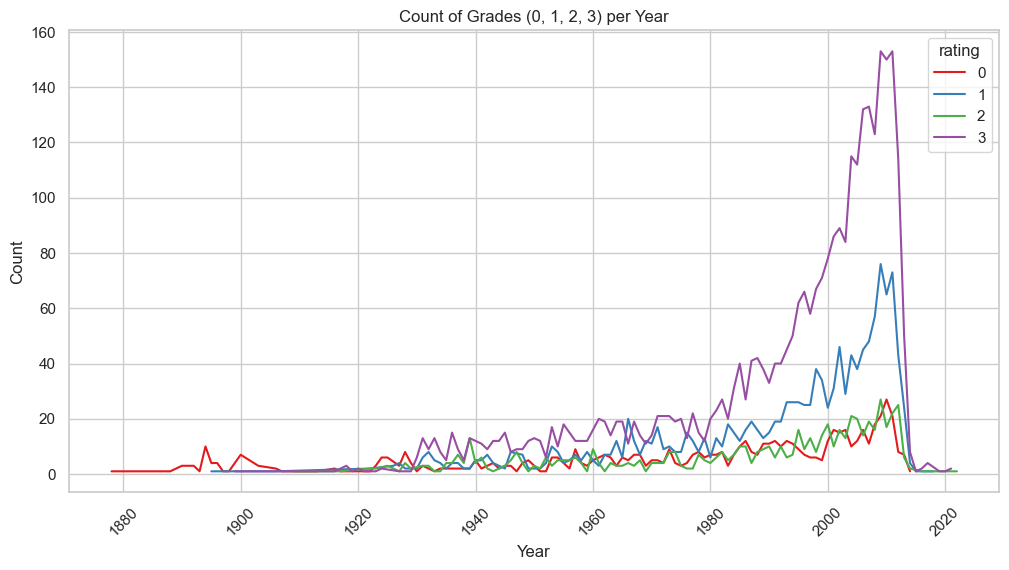

In [62]:
#Plot Grades per year 
sns.set(style="whitegrid")

# Create a line plot with counts
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_x', y='rating', hue='rating', estimator='count', data=merged_df, ci=None,palette='Set1')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Count of Grades (0, 1, 2, 3) per Year')

# Display the plot
plt.show()

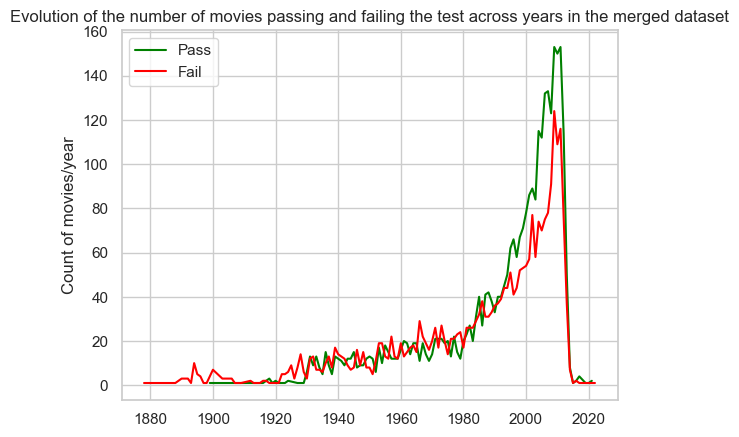

In [63]:
#Class 0,1,2 as fail and 3 as pass
bech_pass = merged_df[merged_df['rating']==3]
bech_fail = merged_df[merged_df['rating']<3]
#Count Passing and failing per year
pass_year = bech_pass.groupby('year_x').count()
fail_year = bech_fail.groupby('year_x').count()
plt.plot(pass_year.index,pass_year['id'], color='green', label ='Pass')
plt.plot(fail_year.index, fail_year['id'], color = 'red', label = 'Fail')
plt.ylabel('Count of movies/year')
plt.title('Evolution of the number of movies passing and failing the test across years in the merged dataset')
plt.legend()

Text(0.5, 1.0, 'Proportion of movies passing the Bechdel test each year')

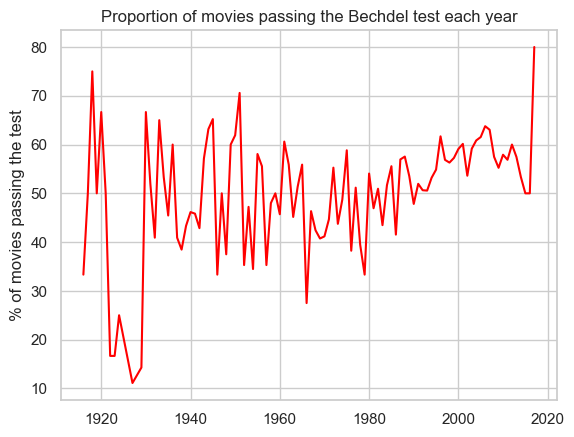

In [65]:
#Fraction of movies passing the test
pass_fail = pd.merge(pass_year, fail_year, left_on='year_x', right_on='year_x', how='inner')
plt.plot(pass_fail.index,(pass_fail['id_x']/(pass_fail['id_y']+pass_fail['id_x']))*100, color='red')
plt.ylabel('% of movies passing the test')
plt.title('Proportion of movies passing the Bechdel test each year')

In [94]:
percentage_year = (pass_fail['id_x']/(pass_fail['id_y']+pass_fail['id_x']))*100
stats.spearmanr(pass_fail.index, percentage_year)

SignificanceResult(statistic=0.34108911560345156, pvalue=0.000550479598119025)

With the Spearman correlation results, we can conclude at the 0.5% confidence level that the percentage of films that pass the Bechdel test is correlated. We also see that there are some strange values in the early half of the 20th century, probably because there are less movies at this time so the percentages are less representative. In the future, we will likely get rid of years during which we have less than a certain threshold of movies.

### 4.2 Movie Genre

Investigating movie genres is challenging, because a single movies may have mutiple genres. The genre column in the CMU dataset contains tuples. Thus we must first split the elements of the tuples to extract all genres.

In [69]:
# Convert the string representation of tuples to actual tuples
merged_df['genres'] = merged_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Explode the 'genres' column to create separate rows for each genre tuple
merged_exploded = merged_df.explode('genres')
unique_ids_genre = merged_exploded['genres'].unique()

#List with IDs of the 10 most present genres in the merged dataset
top10_genres = merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index[0:10]
top10_genres

#Filter Merged with top 10
top10_merged = merged_exploded[merged_exploded['genres'].isin(top10_genres)]

In [73]:
#Genre IDs are not interpretable, we create a dictionnary with genre names associated to IDs
top10_dic = {"/m/01jfsb": "Thriller", "/m/03npn": "Horror",
             "/m/0lsxr":"Crime Fiction", "/m/03k9fj":"Adventure",
             "/m/07s9rl0":"Drama","/m/02l7c8":"Romance Film",
             "/m/01z4y":"Comedy","/m/03q4nz": "World cinema",
             "/m/03btsm8":"Action/Adventure","/m/02kdv5l":"Action",
            "/m/0219x_": "Indie"}

/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/1555576718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_merged['genres'] = top10_merged['genres'].replace(top10_dic) #Assign genre names


Text(0, 0.5, 'Number of movies in the merged dataset')

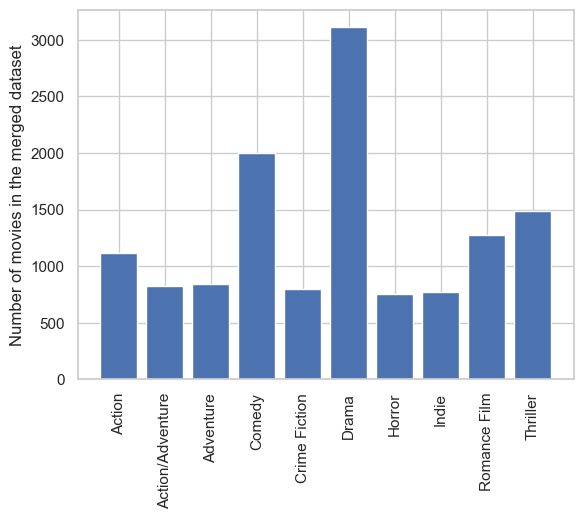

In [75]:
#Barplot showing the top 10 genres
top10_merged['genres'] = top10_merged['genres'].replace(top10_dic) #Assign genre names

plt.bar(top10_merged.groupby('genres').count().index,top10_merged.groupby('genres').count()['id'])
plt.xticks(rotation=90)
plt.ylabel('Number of movies in the merged dataset')

We have shown what Movie Genres are the most represented in our dataset. The future analysis will focus on these top 10 genres.

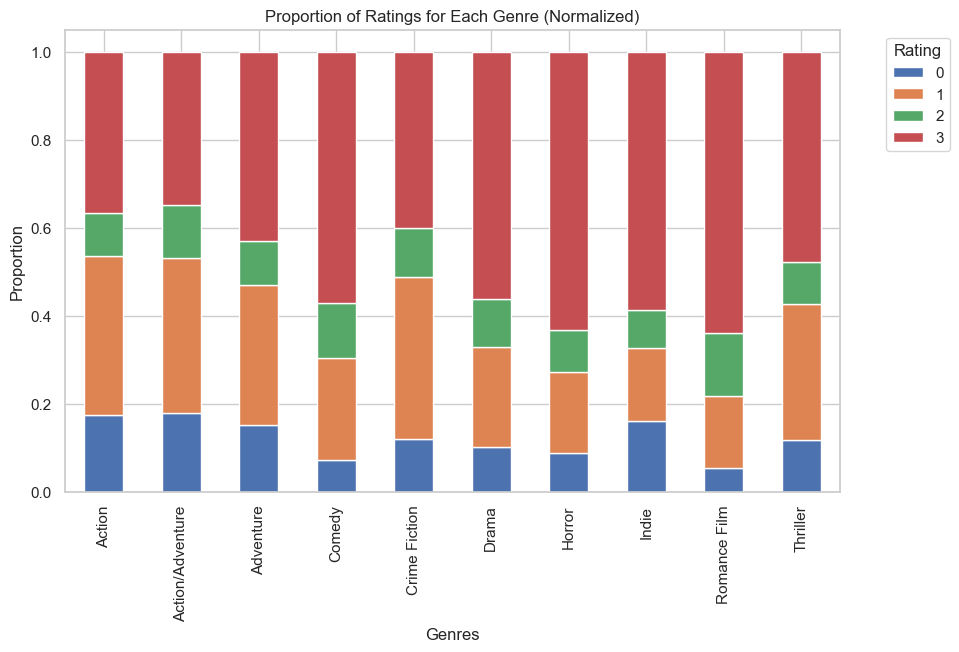

In [82]:
# Group by 'genres' and 'rating', and calculate proportions
genre_rating_proportions = top10_merged.groupby(['genres', 'rating']).size() / top10_merged.groupby('genres').size()

# Reset the index to make it a DataFrame
genre_rating_proportions = genre_rating_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'rating' as columns
genre_rating_proportions_pivot = genre_rating_proportions.pivot(index='genres', columns='rating', values='proportion')

# Plotting
ax = genre_rating_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Proportion')
ax.set_xlabel('Genres')
ax.set_title('Proportion of Ratings for Each Genre (Normalized)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 4.3 Movie Country

In [98]:
merged_df['countries'] = merged_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
bech_pass = merged_df[merged_df['rating']==3]
bech_fail = merged_df[merged_df['rating']<3]

In [99]:
#We count passing and failing per country
#The challenge is the same as genres: we must explode the tuples 
bech_pass['countries'] = bech_pass['countries'].apply(lambda x: [(k, v) for k, v in x.items()])
bech_fail['countries'] = bech_fail['countries'].apply(lambda x: [(k, v) for k, v in x.items()])
pass_country_exp = bech_pass.explode('countries')
fail_country_exp = bech_fail.explode('countries')
passed_per_country = pass_country_exp['countries'].value_counts().reset_index()
failed_per_country = fail_country_exp['countries'].value_counts().reset_index()
passed_per_country.columns = ['countries', 'Movie Count']
failed_per_country.columns = ['countries', 'Movie Count']

/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/3820965980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bech_pass['countries'] = bech_pass['countries'].apply(lambda x: [(k, v) for k, v in x.items()])
/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/3820965980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bech_fail['countries'] = bech_fail['countries'].apply(lambda x: [(k, v) for k, v in x.items()])


/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/2766788957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries['countries_str'] = df_sorted['countries'].astype(str)


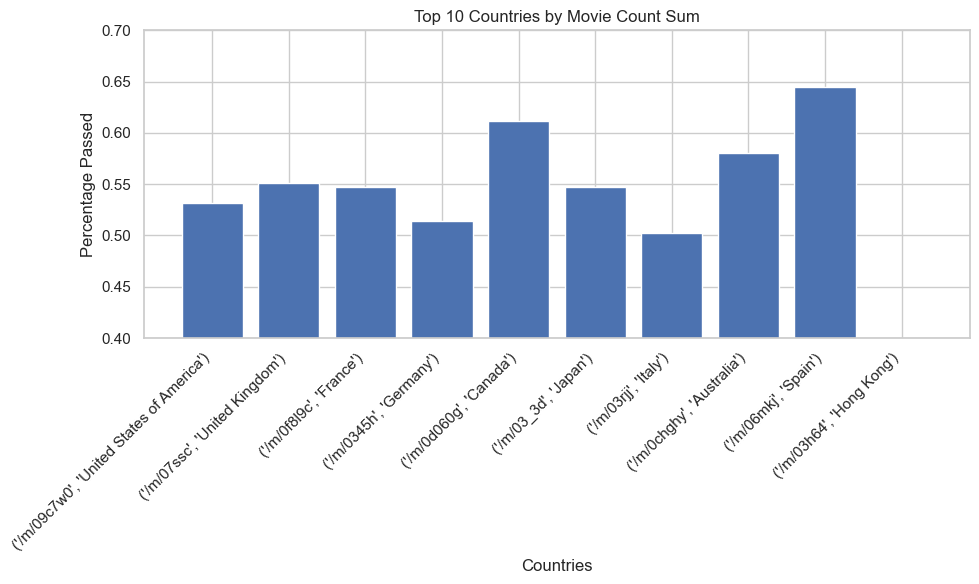

In [103]:
pass_fail_country = pd.merge(passed_per_country, failed_per_country, left_on='countries', right_on='countries', how='inner')
pass_fail_country['percentage passed'] = pass_fail_country['Movie Count_x']/(pass_fail_country['Movie Count_x']+pass_fail_country['Movie Count_y'])
pass_fail_country['Movie Count Sum'] = pass_fail_country['Movie Count_x'] + pass_fail_country['Movie Count_y']

# Sort the DataFrame to extract the top 10 countries
df_sorted = pass_fail_country.sort_values(by='Movie Count Sum', ascending=False)

top_10_countries = df_sorted.head(10)
# Select the top 10 rows
top_10_countries['countries_str'] = df_sorted['countries'].astype(str)

# Create a bar plot of the percentages for these ten countries
plt.figure(figsize=(10, 6))
plt.bar(top_10_countries['countries_str'], top_10_countries['percentage passed'])
plt.xlabel('Countries')
plt.ylabel('Percentage Passed')
plt.title('Top 10 Countries by Movie Count Sum')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0.4, 0.7)

plt.tight_layout()
plt.show()

From the bar chart of the ten countries for which we have the most data, the percentage of films that pass the test does not seem to depend on the country of release.We note that we have the most data for mostly western countries, with the exception of Japan and India, so our dataset is obviously biased. We can thus imagine that subsequently instead of using country as a factor, we could use global region or GDP baskets to compare quantities of movies that pass the test. 

### 4.4 Movie Box Office revenue --> too many NaNs ?

In [67]:
#Check the proportion of NaNs values in the column 'Movie box office revenue' in the merged dataframe
nan_sum = merged_df['Movie box office revenue'].isna().sum()
print("Proportion of NaN values in 'Movie box office revenue': {:.2%}".format(nan_sum/len(merged_df)))

Proportion of NaN values in 'Movie box office revenue': 43.62%


We have much less NaNs values than in the orginal CMU dataset! This means that it will be able to do analysis on the revenue of movies passing or not the Bechdel Test

In [104]:
#Create a copy without the Nans values of revenues
revenue_df = bech_pass.dropna(subset=['Movie box office revenue']).copy()

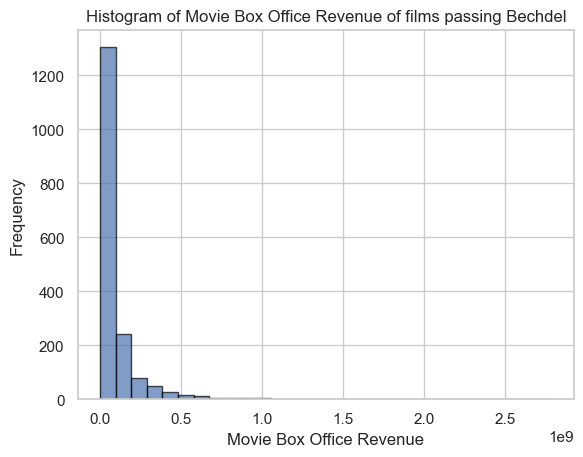

In [105]:
#Define bins for the histogram
bins = np.linspace(revenue_df['Movie box office revenue'].min(), revenue_df['Movie box office revenue'].max(), 30)

# Plot the histogram
plt.hist(revenue_df['Movie box office revenue'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Box Office Revenue of films passing Bechdel')
plt.show()

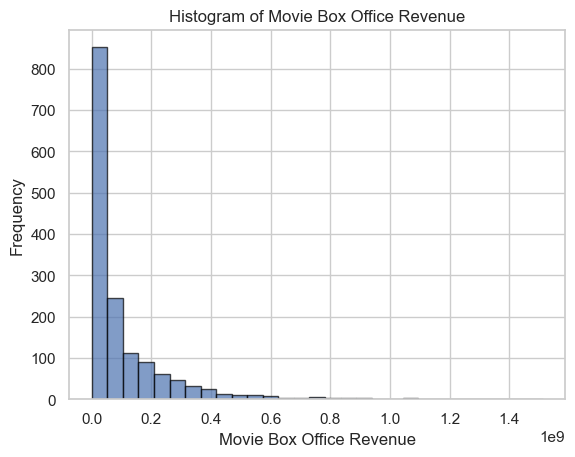

In [106]:
#Drop Na values of the bechdel fail dataframe
revenue_fail_df = bech_fail.dropna(subset=['Movie box office revenue']).copy()
bins = np.linspace(revenue_fail_df['Movie box office revenue'].min(), revenue_fail_df['Movie box office revenue'].max(), 30)

# Plot the histogram
plt.hist(revenue_fail_df['Movie box office revenue'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Box Office Revenue')
plt.show()

/var/folders/gv/p0_wcycs0nj1gfgnyvh8ndl00000gn/T/ipykernel_90646/2911124039.py:7: RuntimeWarning: invalid value encountered in divide
  pass_percentage = np.histogram(revenue_df['Movie box office revenue'], bins=bins)[0] / total_films_per_bin


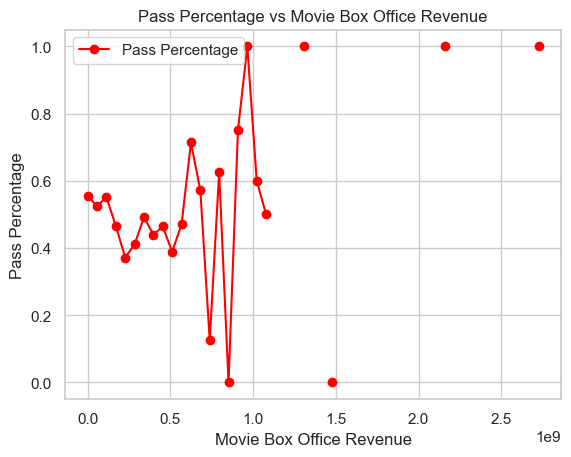

In [107]:
bins = np.linspace(min(min(revenue_fail_df['Movie box office revenue']), min(revenue_df['Movie box office revenue'])),
                   max(max(revenue_fail_df['Movie box office revenue']), max(revenue_df['Movie box office revenue'])),
                   50)

# Calculate the percentage of films that pass for each bin
total_films_per_bin = np.histogram(revenue_fail_df['Movie box office revenue'], bins=bins)[0] + np.histogram(revenue_df['Movie box office revenue'], bins=bins)[0]
pass_percentage = np.histogram(revenue_df['Movie box office revenue'], bins=bins)[0] / total_films_per_bin

# Plot the line representing the percentage of films that pass for each revenue
plt.plot(bins[:-1], pass_percentage, color='red', marker='o', label='Pass Percentage')

plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Pass Percentage')
plt.title('Pass Percentage vs Movie Box Office Revenue')
plt.legend()
plt.show()

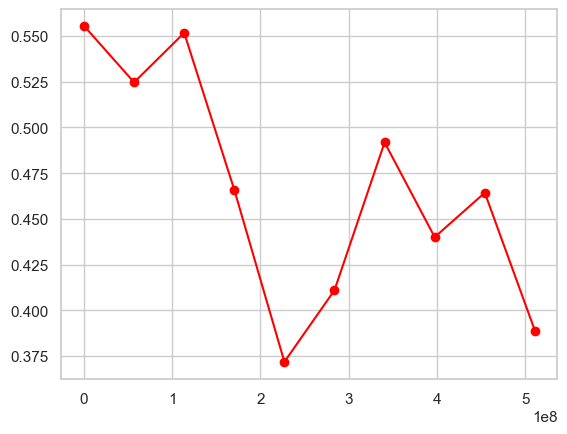

In [108]:
valid_bins = bins[:-1][total_films_per_bin >= 10]

# Create a mask to filter out movies falling within those bins
mask = revenue_df['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)
mask1 = revenue_fail_df['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)

# Use the mask to drop movies from both dataframes
revenue_df_filtered = revenue_df[mask]
revenue_fail_df_filtered = revenue_fail_df[mask1]

# Now you can proceed with plotting the pass percentage using revenue_df_filtered
pass_counts = np.histogram(revenue_df_filtered['Movie box office revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin[total_films_per_bin >= 10][:len(pass_counts)].ravel()

# Avoid division by zero
pass_percentage = np.divide(pass_counts, total_films_per_bin_1d, out=np.zeros_like(pass_counts, dtype=float), where=total_films_per_bin_1d != 0)

# Plot the line representing the percentage of films that pass for each valid bin
plt.plot(valid_bins[:-1], pass_percentage, color='red', marker='o', label='Pass Percentage')

In [109]:
#Spearman Test
stats.spearmanr(valid_bins[:-1], pass_percentage)

SignificanceResult(statistic=-0.6848484848484848, pvalue=0.02888279750673276)

From the data for the percentage of films that pass the Bechdel test as a function of revenue, considering only revenue baskets where we have data for 10 or more films, we note a significant correlation which is negative. This is corroborated by the spearman test. This basically means that films that pass the Bechdel test generally earn less than those that don't. 

### 4.5 Movie Production

The CMU dataset does not contain the production company. We will request it with the Wikipedia API from the wikipedia IDs

In [84]:
# Create a new column 'Production Company' in the merged_df 
merged_df['Production Company'] = None

# Iterate over the rows and fill the 'Production Company' column with the previous request function
for index, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Processing Rows"):
    wikipedia_id = row['Wikipedia movie ID']

    try:
        production_company = get_production_company(wikipedia_id)

        # Fill the 'Production Company' column with the obtained value
        merged_df.at[index, 'Production Company'] = production_company

    except KeyError as e:
        print(f"KeyError for Wikipedia ID {wikipedia_id}: {e}")
        # Optionally, you can continue to the next iteration or handle it as needed
        continue


Processing Rows:  16%|███▎                 | 902/5816 [14:19<1:05:23,  1.25it/s]

KeyError for Wikipedia ID 5870858: 'en'


Processing Rows:  24%|████▊               | 1399/5816 [21:49<1:04:49,  1.14it/s]

KeyError for Wikipedia ID 9871454: 'en'


Processing Rows:  62%|█████████████▌        | 3595/5816 [55:33<31:08,  1.19it/s]

KeyError for Wikipedia ID 5443971: 'datavalue'


Processing Rows:  66%|██████████████▍       | 3813/5816 [58:52<38:30,  1.15s/it]

KeyError for Wikipedia ID 1666667: 'en'


Processing Rows:  81%|████████████████▎   | 4738/5816 [1:12:16<19:39,  1.09s/it]

KeyError for Wikipedia ID 18057739: 'datavalue'


Processing Rows:  91%|██████████████████▏ | 5306/5816 [1:20:09<08:43,  1.03s/it]

KeyError for Wikipedia ID 32114086: 'en'


Processing Rows: 100%|████████████████████| 5816/5816 [1:27:39<00:00,  1.11it/s]


In [87]:
merged_df.groupby('Production Company').count()

,Unnamed: 0,imdbid,year_x,rating,id,title,WikiID,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year_y,genres
Production Company,,,,,,,,,,,,,,,,,,
12-Gauge Production,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1492 Pictures,5,5,5,5,5,5,5,5,5,5,5,4,4,5,5,5,5,5
2003 Productions,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20th Century Animation,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20th Century Studios,220,220,220,220,220,220,220,220,220,220,183,154,213,220,220,220,183,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
di Bonaventura Pictures,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
micro_scope,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
y3 film Hans Weingärtner Filmproduktion,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1


In [89]:
print(f"Proportion of NaNs in 'Production Company' column  (%): {round(100*(merged_df['Production Company'].isnull().sum()/len(merged_df)),2)}")

Proportion of NaNs in 'Production Company' column  (%): 27.82


Further analysis consist of plotting rates proportion for the major production companies. These plots will be computed for the next Milestone